In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import pipeline
from datetime import datetime


In [1]:
pip install streamlit transformers torch


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Load the Kaggle Twitter US Airline Sentiment dataset
df = pd.read_csv(r"C:\Users\jazil\Downloads\archive-twitter (4)\Tweets.csv")  # Update with your full file path
df = df[['tweet_id', 'airline', 'airline_sentiment', 'text', 'tweet_created']]

# Convert tweet_created to datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
df = df.sort_values(by='tweet_created')

df.head()


,tweet_id,airline,airline_sentiment,text,tweet_created
8965,567588278875213824,Delta,neutral,@JetBlue's new CEO seeks the right balance to ...,2015-02-16 23:36:05-08:00
8964,567590027375702016,Delta,negative,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16 23:43:02-08:00
4325,567591480085463040,United,negative,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48-08:00
4324,567592368451248130,United,negative,@united the we got into the gate at IAH on tim...,2015-02-16 23:52:20-08:00
6745,567594449874587648,Southwest,negative,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36-08:00


In [3]:
# Sampling for quick testing (adjust size as needed)
df_sample = df.sample(n=200, random_state=42).reset_index(drop=True)


In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TextClassificationPipeline

# Use distilBERT fine-tuned for sentiment analysis
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", framework="pt")




Device set to use cpu


In [9]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\Users\jazil\Downloads\archive-twitter (4)\Tweets.csv")  # ← Replace with your full path
df = df[['tweet_id', 'text', 'tweet_created']]  # Use only relevant columns

# Convert datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
df = df.sort_values(by='tweet_created')
df.head()


,tweet_id,text,tweet_created
8965,567588278875213824,@JetBlue's new CEO seeks the right balance to ...,2015-02-16 23:36:05-08:00
8964,567590027375702016,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16 23:43:02-08:00
4325,567591480085463040,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48-08:00
4324,567592368451248130,@united the we got into the gate at IAH on tim...,2015-02-16 23:52:20-08:00
6745,567594449874587648,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36-08:00


In [10]:
from tqdm import tqdm
tqdm.pandas()  # for progress bars in pandas

# Sentiment prediction (truncated to 512 chars for safety)
def get_sentiment(text):
    result = classifier(text[:512])[0]
    return result['label'], result['score']

# Apply sentiment analysis
df[['sentiment_label', 'confidence']] = df['text'].progress_apply(
    lambda x: pd.Series(get_sentiment(x))
)
df.head()


100%|██████████| 14640/14640 [31:02<00:00,  7.86it/s] 


,tweet_id,text,tweet_created,sentiment_label,confidence
8965,567588278875213824,@JetBlue's new CEO seeks the right balance to ...,2015-02-16 23:36:05-08:00,5 stars,0.389533
8964,567590027375702016,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16 23:43:02-08:00,5 stars,0.338232
4325,567591480085463040,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48-08:00,2 stars,0.333874
4324,567592368451248130,@united the we got into the gate at IAH on tim...,2015-02-16 23:52:20-08:00,1 star,0.382097
6745,567594449874587648,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36-08:00,3 stars,0.409830


In [12]:
df['sentiment_score'] = df['sentiment_label'].apply(lambda label: int(label.split()[0]))


In [13]:
df['date'] = df['tweet_created'].dt.date

# Daily average sentiment
daily_sentiment = df.groupby('date')['sentiment_score'].mean().reset_index()
daily_sentiment.head()


,date,sentiment_score
0,2015-02-16,3.250000
1,2015-02-17,2.439631
2,2015-02-18,2.450149
3,2015-02-19,2.540698
4,2015-02-20,2.448000


C:\Users\jazil\AppData\Local\Temp\ipykernel_18688\4079494444.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jazil\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


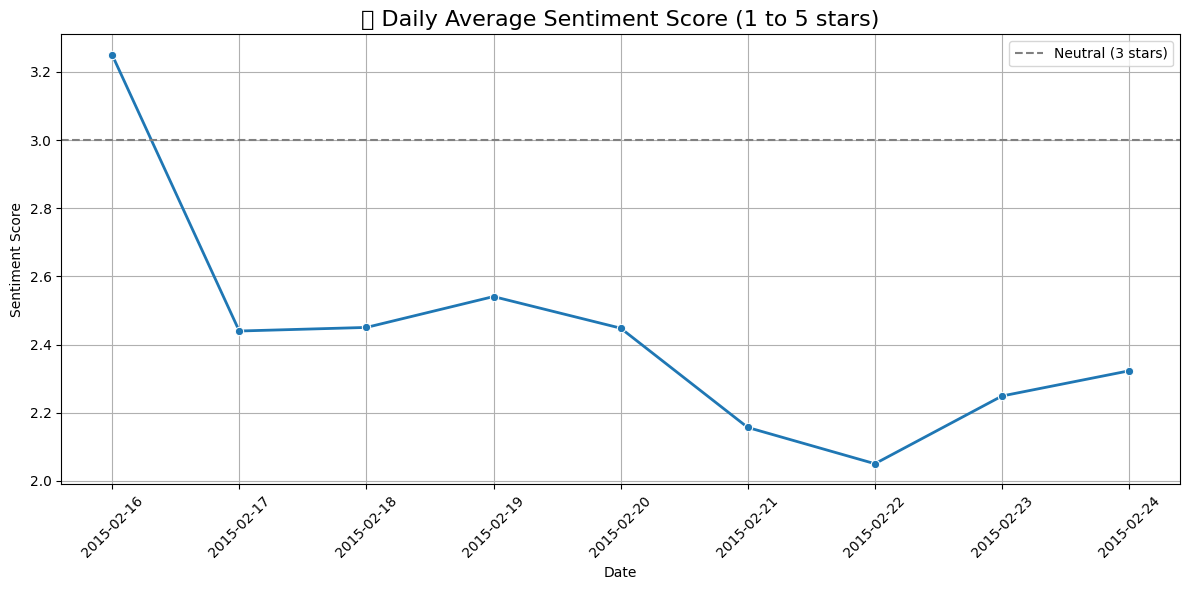

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_sentiment, x='date', y='sentiment_score', marker='o', linewidth=2)
plt.axhline(3, color='gray', linestyle='--', label='Neutral (3 stars)')
plt.title("📊 Daily Average Sentiment Score (1 to 5 stars)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
def predict_sentiment(text):
    result = classifier(text[:512])[0]  # truncate long input
    stars = int(result['label'].split()[0])  # Extract number from '5 stars'
    
    if stars <= 2:
        sentiment = "Negative"
    elif stars == 3:
        sentiment = "Neutral"
    else:
        sentiment = "Positive"
    
    return {
        "text": text,
        "stars": stars,
        "sentiment": sentiment,
        "confidence": result['score']
    }


In [17]:
input_text = "I really hate this product! It works poorly."
prediction = predict_sentiment(input_text)
print(prediction)


{'text': 'I really hate this product! It works poorly.', 'stars': 1, 'sentiment': 'Negative', 'confidence': 0.8240590691566467}


In [4]:
app_code = '''
import streamlit as st
from transformers import pipeline

@st.cache_resource
def load_model():
    return pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", framework="pt")

classifier = load_model()

def predict_sentiment(text):
    result = classifier(text[:512])[0]
    stars = int(result['label'].split()[0])
    if stars <= 2:
        sentiment = "Negative"
    elif stars == 3:
        sentiment = "Neutral"
    else:
        sentiment = "Positive"
    return sentiment, stars, result['score']

st.title(" BERT Sentiment Analyzer")
st.write("Enter text below to get sentiment prediction.")

user_input = st.text_area("Your Text", height=150)

if st.button("Analyze"):
    if user_input.strip():
        sentiment, stars, confidence = predict_sentiment(user_input)
        st.markdown(f"### Sentiment: **{sentiment}** ({stars} stars)")
        st.markdown(f"Confidence Score: {confidence:.2f}")
    else:
        st.warning("Please enter some text to analyze.")
'''

with open("app.py", "w", encoding="utf-8") as f:
    f.write(app_code)



In [ ]:
!streamlit run app.py
